# A. Importing and cleaning the data

In [1]:
import numpy as np
import pandas as pd
import re
import sqlite3
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("en.openfoodfacts.org.products.tsv", sep='\t', low_memory=False )
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# get an overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


In [4]:
# getting an idea of all the columns in order to detrmine, what I want to analyze

col=df.columns
len(col)
for i in range(len(col)-1):
    print(df.columns[i])


code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
generic_name
quantity
packaging
packaging_tags
brands
brands_tags
categories
categories_tags
categories_en
origins
origins_tags
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_en
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_en
ingredients_text
allergens
allergens_en
traces
traces_tags
traces_en
serving_size
no_nutriments
additives_n
additives
additives_tags
additives_en
ingredients_from_palm_oil_n
ingredients_from_palm_oil
ingredients_from_palm_oil_tags
ingredients_that_may_be_from_palm_oil_n
ingredients_that_may_be_from_palm_oil
ingredients_that_may_be_from_palm_oil_tags
nutrition_grade_uk
nutrition_grade_fr
pnns_groups_1
pnns_groups_2
states
states_tags
states_en
main_category
main_category_en
image_url
image_small_url
energy_100g
energy-from-fat_100g
fat_100g
saturated-fat_100g
-buty

In [5]:
# I intend to analyze the ratio of the various groups of fat by brands,
# country and food category. I make a pre-selection of the columns and
# will in a next step further analyze, which columns are best suited for
# my analysis and to what extend I have to clean data.

df2 = df[["product_name","url","creator","created_datetime","last_modified_datetime","countries","countries_tags","countries_en","brands","brands_tags","categories","categories_tags","categories_en","fat_100g","saturated-fat_100g","monounsaturated-fat_100g","polyunsaturated-fat_100g","ingredients_text"]]          

In [6]:
# get an idea for which category, what amount of data is available.
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 18 columns):
product_name                338515 non-null object
url                         356001 non-null object
creator                     356024 non-null object
created_datetime            356017 non-null object
last_modified_datetime      356027 non-null object
countries                   355752 non-null object
countries_tags              355752 non-null object
countries_en                355752 non-null object
brands                      326977 non-null object
brands_tags                 326957 non-null object
categories                  103299 non-null object
categories_tags             103275 non-null object
categories_en               103301 non-null object
fat_100g                    279497 non-null float64
saturated-fat_100g          263823 non-null float64
monounsaturated-fat_100g    23040 non-null float64
polyunsaturated-fat_100g    23075 non-null float64
ingredients_text    

In [7]:
# There are plenty of non values
df2.isnull().sum()

product_name                 17512
url                             26
creator                          3
created_datetime                10
last_modified_datetime           0
countries                      275
countries_tags                 275
countries_en                   275
brands                       29050
brands_tags                  29070
categories                  252728
categories_tags             252752
categories_en               252726
fat_100g                     76530
saturated-fat_100g           92204
monounsaturated-fat_100g    332987
polyunsaturated-fat_100g    332952
ingredients_text             72134
dtype: int64

In [8]:
# There are no duplicated rows
df2.duplicated().sum()

0

In [9]:
# However, many products appear several times. I will take care of it later.
df2["product_name"].duplicated().sum()

106781

In [10]:
# I am interested to see which product has saturated fat and which has unsaturated fat
# drop all the rows where all the three columns "saturated_fat, mono_ - or poly-saturated fat are NA
df2 = df2.loc[((df2['fat_100g'].notnull() & (df2['saturated-fat_100g'].notnull()) & (df2['monounsaturated-fat_100g'].notnull()) & (df2['polyunsaturated-fat_100g'].notnull())))]
df2

,product_name,url,creator,created_datetime,last_modified_datetime,countries,countries_tags,countries_en,brands,brands_tags,categories,categories_tags,categories_en,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,ingredients_text
182,Chaussons tressés aux pommes,http://world-en.openfoodfacts.org/product/0000...,b7,2017-01-15T17:32:08Z,2017-01-15T18:29:32Z,Canada,en:canada,Canada,Kirkland Signature,kirkland-signature,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries","en:sugary-snacks,en:biscuits-and-cakes,en:past...","Sugary snacks,Biscuits and cakes,Pastries",10.70,2.00,3.33,5.33,"Ingrédients : Pâte (farine, margarines d'huile..."
264,100% Pure Canola Oil,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T09:41:13Z,2017-03-09T09:41:13Z,US,en:united-states,United States,Canola Harvest,canola-harvest,NaN,NaN,NaN,100.00,7.14,64.29,25.00,100% canola oil .
265,Original Buttery Spread,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T12:10:54Z,2017-03-09T12:10:55Z,US,en:united-states,United States,NaN,NaN,NaN,NaN,NaN,71.43,10.71,42.86,17.86,"Canola oil, water, palm oil, palm kernel oil, ..."
266,"Buttery Spread, With Flaxseed Oil",http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T09:49:30Z,2017-03-09T09:49:30Z,US,en:united-states,United States,Canola Harvest,canola-harvest,NaN,NaN,NaN,57.14,10.71,32.14,14.29,"Canola oil, water, palm oil, flax oil, palm ke..."
282,"Bakers Best, Rye Bread",http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T16:43:21Z,2017-03-09T16:43:21Z,US,en:united-states,United States,Wise Woodworks,wise-woodworks,NaN,NaN,NaN,2.56,0.00,0.00,1.28,"Enriched bleached flour (wheat flour, malt bar..."
315,Sea Salt Potato Chips,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,2014-07-12T19:37:43Z,2017-03-09T11:35:38Z,United States,en:united-states,United States,Trader Joe's,trader-joe-s,"Chips,Chips and fries","en:chips-and-fries,en:chips","Chips and fries,Chips",32.14,3.57,25.00,3.57,"Unpeeled potatoes, sunflower oil, sea salt."
450,Tofu Firm,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-09T12:30:58Z,2017-03-09T12:30:58Z,US,en:united-states,United States,Simple Truth Organic,simple-truth-organic,NaN,NaN,NaN,3.80,0.00,1.27,2.53,"Water, organic whole soybeans, calcium sulfate..."
480,Imported Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:38Z,2017-03-10T10:55:38Z,US,en:united-states,United States,Trader Giotto's,trader-giotto-s,NaN,NaN,NaN,93.33,13.33,66.67,10.00,"Refined olive oil, extra virgin olive oil."
482,Extra Virgin Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:35Z,2017-03-10T10:55:35Z,US,en:united-states,United States,"Trader Giotto's, Ciel De Bleu Inc.","trader-giotto-s,ciel-de-bleu-inc",NaN,NaN,NaN,93.33,13.33,66.67,10.00,Extra virgin olive oil
483,Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:40Z,2017-03-10T10:55:40Z,US,en:united-states,United States,"Trader Giotto's, Sk Wear","trader-giotto-s,sk-wear",NaN,NaN,NaN,93.33,13.33,66.67,10.00,Extra virgin olive oil


In [11]:
df2.shape

(22785, 18)

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22785 entries, 182 to 356022
Data columns (total 18 columns):
product_name                22708 non-null object
url                         22785 non-null object
creator                     22785 non-null object
created_datetime            22785 non-null object
last_modified_datetime      22785 non-null object
countries                   22782 non-null object
countries_tags              22782 non-null object
countries_en                22782 non-null object
brands                      22590 non-null object
brands_tags                 22590 non-null object
categories                  2365 non-null object
categories_tags             2365 non-null object
categories_en               2365 non-null object
fat_100g                    22785 non-null float64
saturated-fat_100g          22785 non-null float64
monounsaturated-fat_100g    22785 non-null float64
polyunsaturated-fat_100g    22785 non-null float64
ingredients_text            22478 non

In [13]:
# get rid of all the nan values for countries, product_name and brands
df2.dropna(subset=["countries_en","product_name","brands","creator","created_datetime"], inplace=True)

In [14]:
# get rid of columns that have the same data just in another format
df2.drop(["countries","countries_tags","categories","categories_tags","brands_tags"], axis=1, inplace=True)

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22555 entries, 182 to 356022
Data columns (total 13 columns):
product_name                22555 non-null object
url                         22555 non-null object
creator                     22555 non-null object
created_datetime            22555 non-null object
last_modified_datetime      22555 non-null object
countries_en                22555 non-null object
brands                      22555 non-null object
categories_en               2339 non-null object
fat_100g                    22555 non-null float64
saturated-fat_100g          22555 non-null float64
monounsaturated-fat_100g    22555 non-null float64
polyunsaturated-fat_100g    22555 non-null float64
ingredients_text            22318 non-null object
dtypes: float64(4), object(9)
memory usage: 2.4+ MB


In [16]:
# check whether we still have some duplicates
df2["product_name"].duplicated().sum()

6629

In [17]:
# drop the duplicates in the products_names column. We don't want to consider
# several times the same product
df2.drop_duplicates(['product_name'], inplace=True)

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15926 entries, 182 to 356022
Data columns (total 13 columns):
product_name                15926 non-null object
url                         15926 non-null object
creator                     15926 non-null object
created_datetime            15926 non-null object
last_modified_datetime      15926 non-null object
countries_en                15926 non-null object
brands                      15926 non-null object
categories_en               2029 non-null object
fat_100g                    15926 non-null float64
saturated-fat_100g          15926 non-null float64
monounsaturated-fat_100g    15926 non-null float64
polyunsaturated-fat_100g    15926 non-null float64
ingredients_text            15721 non-null object
dtypes: float64(4), object(9)
memory usage: 1.7+ MB


# B. Manipulation the data

In [19]:
df2["Ratio_fat_to_sat_fat"] = (df2["saturated-fat_100g"] / df2["fat_100g"])
df2["Ratio_fat_to_mono_unsat_fat"] = (df2["monounsaturated-fat_100g"] / df2["fat_100g"])
df2["Ratio_fat_to_poly_unsat_fat"] = (df2["polyunsaturated-fat_100g"] / df2["fat_100g"])
df2.dropna(subset=["Ratio_fat_to_sat_fat","Ratio_fat_to_mono_unsat_fat","Ratio_fat_to_poly_unsat_fat"], inplace=True)
df2


,product_name,url,creator,created_datetime,last_modified_datetime,countries_en,brands,categories_en,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,ingredients_text,Ratio_fat_to_sat_fat,Ratio_fat_to_mono_unsat_fat,Ratio_fat_to_poly_unsat_fat
182,Chaussons tressés aux pommes,http://world-en.openfoodfacts.org/product/0000...,b7,2017-01-15T17:32:08Z,2017-01-15T18:29:32Z,Canada,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",10.70,2.00,3.33,5.33,"Ingrédients : Pâte (farine, margarines d'huile...",0.186916,0.311215,0.498131
264,100% Pure Canola Oil,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T09:41:13Z,2017-03-09T09:41:13Z,United States,Canola Harvest,NaN,100.00,7.14,64.29,25.00,100% canola oil .,0.071400,0.642900,0.250000
266,"Buttery Spread, With Flaxseed Oil",http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T09:49:30Z,2017-03-09T09:49:30Z,United States,Canola Harvest,NaN,57.14,10.71,32.14,14.29,"Canola oil, water, palm oil, flax oil, palm ke...",0.187434,0.562478,0.250088
282,"Bakers Best, Rye Bread",http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T16:43:21Z,2017-03-09T16:43:21Z,United States,Wise Woodworks,NaN,2.56,0.00,0.00,1.28,"Enriched bleached flour (wheat flour, malt bar...",0.000000,0.000000,0.500000
315,Sea Salt Potato Chips,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,2014-07-12T19:37:43Z,2017-03-09T11:35:38Z,United States,Trader Joe's,"Chips and fries,Chips",32.14,3.57,25.00,3.57,"Unpeeled potatoes, sunflower oil, sea salt.",0.111077,0.777847,0.111077
450,Tofu Firm,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-09T12:30:58Z,2017-03-09T12:30:58Z,United States,Simple Truth Organic,NaN,3.80,0.00,1.27,2.53,"Water, organic whole soybeans, calcium sulfate...",0.000000,0.334211,0.665789
480,Imported Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:38Z,2017-03-10T10:55:38Z,United States,Trader Giotto's,NaN,93.33,13.33,66.67,10.00,"Refined olive oil, extra virgin olive oil.",0.142827,0.714347,0.107147
482,Extra Virgin Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:35Z,2017-03-10T10:55:35Z,United States,"Trader Giotto's, Ciel De Bleu Inc.",NaN,93.33,13.33,66.67,10.00,Extra virgin olive oil,0.142827,0.714347,0.107147
483,Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:40Z,2017-03-10T10:55:40Z,United States,"Trader Giotto's, Sk Wear",NaN,93.33,13.33,66.67,10.00,Extra virgin olive oil,0.142827,0.714347,0.107147
485,Peanut Butter,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-09T12:15:59Z,2017-03-09T12:15:59Z,United States,Trader Joe's,NaN,50.00,7.81,25.00,15.62,Dry roasted peanuts.,0.156200,0.500000,0.312400


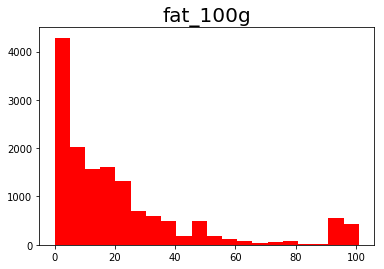

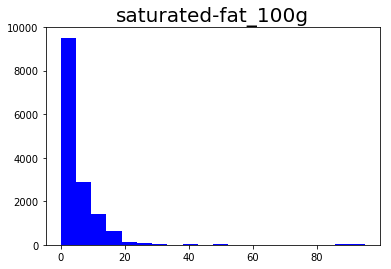

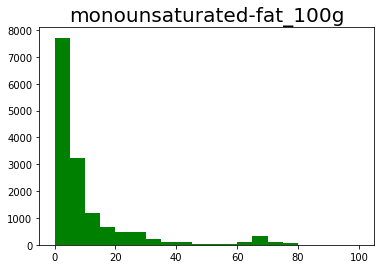

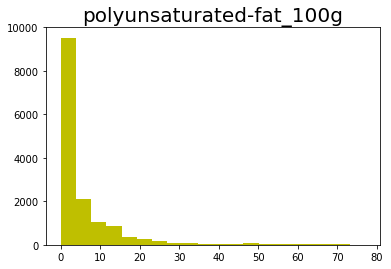

In [20]:
a=df2["fat_100g"]
b=df2["saturated-fat_100g"]
c=df2["monounsaturated-fat_100g"]
d=df2["polyunsaturated-fat_100g"]
X=np.arange(df2["product_name"].count())
plt.hist(a, 20, color='r', stacked=True)
plt.title("fat_100g", size=20)
plt.show()
plt.hist(b, 20, color='b', stacked=True)
plt.title("saturated-fat_100g", size=20)
plt.show()
plt.hist(c, 20, color='g', stacked=True)
plt.title("monounsaturated-fat_100g", size=20)
plt.show()
plt.hist(d, 20, color='y', stacked=True)
plt.title("polyunsaturated-fat_100g", size=20)
plt.show()

In [21]:
# Getting rid of the extreme values (greater than 100, smaller than 0)
df2 = df2.loc[(df["fat_100g"] <= 100) & (df2["fat_100g"] > 0)]
df2 = df2.loc[(df["saturated-fat_100g"] <= 100) & (df["saturated-fat_100g"] > 0)]
df2 = df2.loc[(df["monounsaturated-fat_100g"] <= 100) & (df["monounsaturated-fat_100g"] > 0)]
df2 = df2.loc[(df["polyunsaturated-fat_100g"] <= 100) & (df["polyunsaturated-fat_100g"] > 0)]
df2

,product_name,url,creator,created_datetime,last_modified_datetime,countries_en,brands,categories_en,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,ingredients_text,Ratio_fat_to_sat_fat,Ratio_fat_to_mono_unsat_fat,Ratio_fat_to_poly_unsat_fat
182,Chaussons tressés aux pommes,http://world-en.openfoodfacts.org/product/0000...,b7,2017-01-15T17:32:08Z,2017-01-15T18:29:32Z,Canada,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",10.70,2.00,3.33,5.33,"Ingrédients : Pâte (farine, margarines d'huile...",0.186916,0.311215,0.498131
264,100% Pure Canola Oil,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T09:41:13Z,2017-03-09T09:41:13Z,United States,Canola Harvest,NaN,100.00,7.14,64.29,25.00,100% canola oil .,0.071400,0.642900,0.250000
266,"Buttery Spread, With Flaxseed Oil",http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,2017-03-09T09:49:30Z,2017-03-09T09:49:30Z,United States,Canola Harvest,NaN,57.14,10.71,32.14,14.29,"Canola oil, water, palm oil, flax oil, palm ke...",0.187434,0.562478,0.250088
315,Sea Salt Potato Chips,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,2014-07-12T19:37:43Z,2017-03-09T11:35:38Z,United States,Trader Joe's,"Chips and fries,Chips",32.14,3.57,25.00,3.57,"Unpeeled potatoes, sunflower oil, sea salt.",0.111077,0.777847,0.111077
480,Imported Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:38Z,2017-03-10T10:55:38Z,United States,Trader Giotto's,NaN,93.33,13.33,66.67,10.00,"Refined olive oil, extra virgin olive oil.",0.142827,0.714347,0.107147
482,Extra Virgin Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:35Z,2017-03-10T10:55:35Z,United States,"Trader Giotto's, Ciel De Bleu Inc.",NaN,93.33,13.33,66.67,10.00,Extra virgin olive oil,0.142827,0.714347,0.107147
483,Olive Oil,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-10T10:55:40Z,2017-03-10T10:55:40Z,United States,"Trader Giotto's, Sk Wear",NaN,93.33,13.33,66.67,10.00,Extra virgin olive oil,0.142827,0.714347,0.107147
485,Peanut Butter,http://world-en.openfoodfacts.org/product/0001...,usda-ndb-import,2017-03-09T12:15:59Z,2017-03-09T12:15:59Z,United States,Trader Joe's,NaN,50.00,7.81,25.00,15.62,Dry roasted peanuts.,0.156200,0.500000,0.312400
552,"Ventura, Soybean - Peanut Frying Oil Blend",http://world-en.openfoodfacts.org/product/0002...,usda-ndb-import,2017-03-09T16:51:17Z,2017-03-09T16:51:17Z,United States,Ventura Foods L.L.C.,NaN,100.00,17.86,32.14,42.86,"Peanut oil, soybean oil, tbhq and citric acid ...",0.178600,0.321400,0.428600
633,Barbecue Sauce,http://world-en.openfoodfacts.org/product/0004...,kiliweb,2017-02-13T11:52:10Z,2017-03-09T12:12:54Z,"France,United States","Mark And Spencer, Trader Joe's",NaN,7.50,0.80,2.50,2.50,NaN,0.106667,0.333333,0.333333


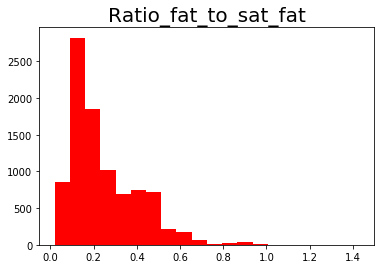

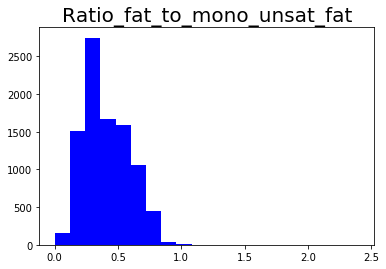

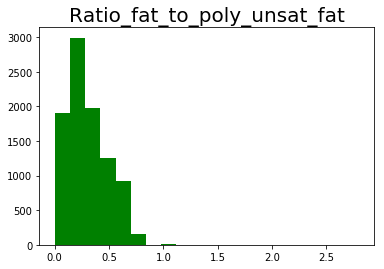

In [22]:
a=df2["Ratio_fat_to_sat_fat"]
b=df2["Ratio_fat_to_mono_unsat_fat"]
c=df2["Ratio_fat_to_poly_unsat_fat"]
X=np.arange(df2["product_name"].count())
plt.hist(a, 20, color='r', stacked=True)
plt.title("Ratio_fat_to_sat_fat", size=20)
plt.show()

plt.hist(b, 20, color='b', stacked=True)
plt.title("Ratio_fat_to_mono_unsat_fat", size=20)
plt.show()

plt.hist(c, 20, color='g', stacked=True)
plt.title("Ratio_fat_to_poly_unsat_fat", size=20)
plt.show()


In [32]:
# we want to compare the saturated/unsaturated fat ratios for 5 different countries
def finding_countries(x):
    return df2[df2["countries_en"].str.contains(x)]
    


In [33]:
country_list=["Switzerland","France","United States", "Sweden", "Germany"]
x=pd.DataFrame(index=["Switzerland","France","United States", "Sweden", "Germany"], columns=["mean","median","max","min","count"])
x



,mean,median,max,min,count
Switzerland,NaN,NaN,NaN,NaN,NaN
France,NaN,NaN,NaN,NaN,NaN
United States,NaN,NaN,NaN,NaN,NaN
Sweden,NaN,NaN,NaN,NaN,NaN
Germany,NaN,NaN,NaN,NaN,NaN


In [34]:
# Ratio fat to saturated fat --> By far the biggest dataset comes from the US
# followed by France. Sweden is too small of a sample. It looks like Germany has
# a significantly lower proportion of saturated fat compared to the others
for i in country_list:
    a=finding_countries(i)
    x.loc[i]["mean"]=a["Ratio_fat_to_sat_fat"].mean()
    x.loc[i]["median"]=a["Ratio_fat_to_sat_fat"].median()
    x.loc[i]["min"]=a["Ratio_fat_to_sat_fat"].min()
    x.loc[i]["max"]=a["Ratio_fat_to_sat_fat"].max()
    x.loc[i]["count"]=a["Ratio_fat_to_sat_fat"].count()

x


,mean,median,max,min,count
Switzerland,0.262208,0.2,0.900685,0.0652174,109
France,0.233814,0.173913,0.95,0.02,1090
United States,0.24856,0.199704,1.42901,0.0454372,7377
Sweden,0.251154,0.133333,0.658537,0.0794118,4
Germany,0.214295,0.153846,0.945652,0.06,96


In [35]:
# The US has the smallest proportion of unsaturated fats (healthy fats)
for i in country_list:
    a=finding_countries(i)
    x.loc[i]["mean"]=a["Ratio_fat_to_mono_unsat_fat"].mean()
    x.loc[i]["median"]=a["Ratio_fat_to_mono_unsat_fat"].median()
    x.loc[i]["min"]=a["Ratio_fat_to_mono_unsat_fat"].min()
    x.loc[i]["max"]=a["Ratio_fat_to_mono_unsat_fat"].max()
    x.loc[i]["count"]=a["Ratio_fat_to_mono_unsat_fat"].count()

x

,mean,median,max,min,count
Switzerland,0.449071,0.412371,0.857143,0.0666667,109
France,0.455367,0.40831,2.40417,0.04,1090
United States,0.39891,0.368233,2.334,0.000472144,7377
Sweden,0.481316,0.42619,0.841176,0.231707,4
Germany,0.47612,0.480909,0.85,0.0434783,96


In [36]:
# The swedish data should be ignored again due to the small sample size.
# In this case Switzerland has the smallest portion of poly unsat fats and
# germany the highest.
for i in country_list:
    x.loc[i]["mean"]=a["Ratio_fat_to_poly_unsat_fat"].mean()
    x.loc[i]["median"]=a["Ratio_fat_to_poly_unsat_fat"].median()
    x.loc[i]["min"]=a["Ratio_fat_to_poly_unsat_fat"].min()
    x.loc[i]["max"]=a["Ratio_fat_to_poly_unsat_fat"].max()
    x.loc[i]["count"]=a["Ratio_fat_to_poly_unsat_fat"].count()

x

,mean,median,max,min,count
Switzerland,0.267917,0.2,0.8,0.0219178,109
France,0.289695,0.25,2.15385,0.00953333,1090
United States,0.301906,0.266754,2.79955,0.000472144,7377
Sweden,0.19735,0.168277,0.433333,0.0195122,4
Germany,0.314218,0.260435,1.75,0.0108696,96


In [37]:
# Checking what percentage of products from the US with fat_100g > 40
# contain oil as ingredient
df3=df2.dropna(subset=["ingredients_text"])
perc_oil_US = df2.loc[(df2["fat_100g"] > 40) & (df2["countries_en"] == "United States")& (df2["ingredients_text"].str.contains("oil", case=False))].count() / df2.loc[(df["fat_100g"] > 40) & (df2["countries_en"] == "United States")& (df2["ingredients_text"].notnull())].count()
perc_oil_US

product_name                   0.783568
url                            0.783568
creator                        0.783568
created_datetime               0.783568
last_modified_datetime         0.783568
countries_en                   0.783568
brands                         0.783568
categories_en                  0.894737
fat_100g                       0.783568
saturated-fat_100g             0.783568
monounsaturated-fat_100g       0.783568
polyunsaturated-fat_100g       0.783568
ingredients_text               0.783568
Ratio_fat_to_sat_fat           0.783568
Ratio_fat_to_mono_unsat_fat    0.783568
Ratio_fat_to_poly_unsat_fat    0.783568
dtype: float64

In [38]:
df3[df3["ingredients_text"].str.contains("oil", case=False)].count()

product_name                   5968
url                            5968
creator                        5968
created_datetime               5968
last_modified_datetime         5968
countries_en                   5968
brands                         5968
categories_en                   198
fat_100g                       5968
saturated-fat_100g             5968
monounsaturated-fat_100g       5968
polyunsaturated-fat_100g       5968
ingredients_text               5968
Ratio_fat_to_sat_fat           5968
Ratio_fat_to_mono_unsat_fat    5968
Ratio_fat_to_poly_unsat_fat    5968
dtype: int64

# C. Text data

In [39]:
# Top five ingredients
new = df3.groupby(["ingredients_text"]).count()
top_five=new.sort_values("product_name", ascending=False)
top_five = top_five[0:5] 
top_five

,product_name,url,creator,created_datetime,last_modified_datetime,countries_en,brands,categories_en,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,Ratio_fat_to_sat_fat,Ratio_fat_to_mono_unsat_fat,Ratio_fat_to_poly_unsat_fat
ingredients_text,,,,,,,,,,,,,,,
Extra virgin olive oil,59,59,59,59,59,59,59,0,59,59,59,59,59,59,59
Extra virgin olive oil.,54,54,54,54,54,54,54,1,54,54,54,54,54,54,54
100% whole grain rolled oats.,23,23,23,23,23,23,23,0,23,23,23,23,23,23,23
Olive oil.,18,18,18,18,18,18,18,0,18,18,18,18,18,18,18
Olive oil,18,18,18,18,18,18,18,0,18,18,18,18,18,18,18


# D. Time Series Analysis

In [40]:
df2[["created_datetime","last_modified_datetime"]].head()

,created_datetime,last_modified_datetime
182,2017-01-15T17:32:08Z,2017-01-15T18:29:32Z
264,2017-03-09T09:41:13Z,2017-03-09T09:41:13Z
266,2017-03-09T09:49:30Z,2017-03-09T09:49:30Z
315,2014-07-12T19:37:43Z,2017-03-09T11:35:38Z
480,2017-03-10T10:55:38Z,2017-03-10T10:55:38Z


In [41]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9233 entries, 182 to 355875
Data columns (total 16 columns):
product_name                   9233 non-null object
url                            9233 non-null object
creator                        9233 non-null object
created_datetime               9233 non-null object
last_modified_datetime         9233 non-null object
countries_en                   9233 non-null object
brands                         9233 non-null object
categories_en                  1884 non-null object
fat_100g                       9233 non-null float64
saturated-fat_100g             9233 non-null float64
monounsaturated-fat_100g       9233 non-null float64
polyunsaturated-fat_100g       9233 non-null float64
ingredients_text               9041 non-null object
Ratio_fat_to_sat_fat           9233 non-null float64
Ratio_fat_to_mono_unsat_fat    9233 non-null float64
Ratio_fat_to_poly_unsat_fat    9233 non-null float64
dtypes: float64(7), object(9)
memory usage: 1.5+ M

In [42]:
df2["created_datetime"] = pd.to_datetime(df2["created_datetime"])
df2["last_modified_datetime"] = pd.to_datetime(df2["last_modified_datetime"])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9233 entries, 182 to 355875
Data columns (total 16 columns):
product_name                   9233 non-null object
url                            9233 non-null object
creator                        9233 non-null object
created_datetime               9233 non-null datetime64[ns]
last_modified_datetime         9233 non-null datetime64[ns]
countries_en                   9233 non-null object
brands                         9233 non-null object
categories_en                  1884 non-null object
fat_100g                       9233 non-null float64
saturated-fat_100g             9233 non-null float64
monounsaturated-fat_100g       9233 non-null float64
polyunsaturated-fat_100g       9233 non-null float64
ingredients_text               9041 non-null object
Ratio_fat_to_sat_fat           9233 non-null float64
Ratio_fat_to_mono_unsat_fat    9233 non-null float64
Ratio_fat_to_poly_unsat_fat    9233 non-null float64
dtypes: datetime64[ns](2), float64

In [43]:
# mean difference between the two
time_difference = df2["last_modified_datetime"]-df2["created_datetime"]
time_difference.mean()

Timedelta('101 days 10:29:54.119246')

In [44]:
df2["created_datetime"].min()

Timestamp('2012-03-19 14:34:36')

In [45]:
df2["created_datetime"].max()

Timestamp('2017-09-17 12:13:25')

In [46]:
df2['Month/Year'] = df2['created_datetime'].apply(lambda x: "%d/%d" % (x.year, x.month))
df2['Month/Year'] = pd.to_datetime(df2['Month/Year'])

In [47]:
df2.groupby(['Month/Year'])["product_name"].count().mean()

137.80597014925374

In [48]:
df4 = df2.groupby(['Month/Year'])["product_name"].count()
df4.tail(20)

Month/Year
2016-02-01      23
2016-03-01      38
2016-04-01      50
2016-05-01      39
2016-06-01      27
2016-07-01      23
2016-08-01      13
2016-09-01      40
2016-10-01      41
2016-11-01      21
2016-12-01      39
2017-01-01      45
2017-02-01      98
2017-03-01    7245
2017-04-01      27
2017-05-01      33
2017-06-01      23
2017-07-01      21
2017-08-01      16
2017-09-01      15
Name: product_name, dtype: int64

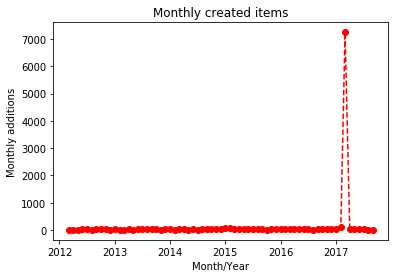

In [49]:
plt.plot(df4.index, df4, 'ro',linestyle='dashed')
plt.xlabel('Month/Year')
plt.ylabel('Monthly additions')
plt.title('Monthly created items')
plt.show()

In [50]:
# We clearly see the outlier in March 2017. Therefore, we replace the Mar 2017 value with the median of all values and plot the same chart again .
df4.sort_values(0, ascending=False)

Month/Year
2017-03-01    7245
2017-02-01      98
2015-02-01      76
2015-01-01      61
2013-08-01      55
2015-04-01      51
2014-11-01      51
2015-07-01      51
2016-04-01      50
2015-08-01      49
2015-03-01      48
2017-01-01      45
2016-10-01      41
2013-09-01      40
2014-10-01      40
2016-09-01      40
2016-12-01      39
2016-05-01      39
2012-07-01      39
2016-03-01      38
2015-09-01      37
2014-08-01      36
2013-07-01      36
2017-05-01      33
2012-11-01      32
2012-06-01      31
2015-06-01      31
2015-12-01      29
2015-05-01      28
2015-11-01      28
              ... 
2014-03-01      24
2012-10-01      24
2016-07-01      23
2016-02-01      23
2017-06-01      23
2013-06-01      22
2012-09-01      22
2016-11-01      21
2017-07-01      21
2013-01-01      20
2014-01-01      20
2013-12-01      20
2014-09-01      20
2016-01-01      20
2014-07-01      19
2013-11-01      18
2015-10-01      18
2014-02-01      17
2013-03-01      17
2012-08-01      17
2017-08-01      16
2

In [51]:
df4.median()

27.0

In [52]:
df4[("2017-03-01")]=27

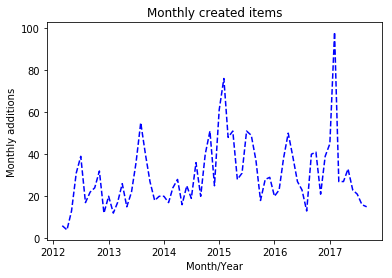

In [53]:
# by replacing the outlier, the chart is much more insightful
plt.plot(df4.index, df4, 'b',linestyle='dashed')
plt.xlabel('Month/Year')
plt.ylabel('Monthly additions')
plt.title('Monthly created items')
plt.show()

# E. Build a Database

In [54]:
db = sqlite3.connect("database_food.db")

In [65]:
df5 = df[["code","brands","product_name", "countries_en", "creator"]]
df5 = df5.iloc[0:1000]
df5.tail()

,code,brands,product_name,countries_en,creator
995,0009300000864,Mt. Olive Pickle Company Inc.,Kosher Dills,United States,usda-ndb-import
996,0009300000888,Mt. Olive,Kosher Dill Spears,United States,usda-ndb-import
997,0009300000895,Mt. Olive Pickle Company Inc.,Pepperoncini,United States,usda-ndb-import
998,0009300000901,Mt. Olive,Sweet 'N' Hot Salad Peppers,United States,usda-ndb-import
999,0009300000925,Mt. Olive Pickle Company Inc.,Sliced Pepperoncini,United States,usda-ndb-import


In [66]:
query = "CREATE TABLE foody (code INTEGER PRIMARY KEY, brands TEXT, product_name TEXT, countries_en TEXT, creator TEXT);"


In [70]:
cursor = db.cursor()
cursor.execute(query)
db.commit()

In [71]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")


In [72]:
results = cursor.fetchall()
print(results)

[('foody',)]


In [73]:
df5.to_sql(name="foody", con=db , if_exists="append", index=False)

In [86]:
query = "SELECT * FROM foody WHERE code > 3000 AND code < 5000" 
cursor.execute(query)


In [87]:
results = cursor.fetchall()
print(results)

[(3087, "Ferme t'y R'nao", 'Farine de blé noir', 'France', 'openfoodfacts-contributors'), (4530, None, 'Banana Chips Sweetened (Whole)', 'United States', 'usda-ndb-import'), (4559, 'Torn & Glasser', 'Peanuts', 'United States', 'usda-ndb-import'), (3001, None, None, 'France', 'date-limite-app'), (3100, 'Sovivo', 'Chair à saucisse', 'France', 'openfoodfacts-contributors'), (4394, "sainsbury's,by sainsbury's", 'tree ripened papaya', 'United Kingdom', 'kyzh')]


In [85]:
df5.sort_values("code", ascending = True)

,code,brands,product_name,countries_en,creator
0,0000000003087,Ferme t'y R'nao,Farine de blé noir,France,openfoodfacts-contributors
1,0000000004530,NaN,Banana Chips Sweetened (Whole),United States,usda-ndb-import
2,0000000004559,Torn & Glasser,Peanuts,United States,usda-ndb-import
3,0000000016087,Grizzlies,Organic Salted Nut Mix,United States,usda-ndb-import
4,0000000016094,Bob's Red Mill,Organic Polenta,United States,usda-ndb-import
5,0000000016100,Unfi,Breadshop Honey Gone Nuts Granola,United States,usda-ndb-import
6,0000000016117,Lundberg,Organic Long Grain White Rice,United States,usda-ndb-import
7,0000000016124,Daddy's Muesli,Organic Muesli,United States,usda-ndb-import
8,0000000016193,Equal Exchange,Organic Dark Chocolate Minis,United States,usda-ndb-import
9,0000000016513,Napa Valley Naturals,Organic Sunflower Oil,United States,usda-ndb-import


In [88]:
query = "SELECT brands,countries_en FROM foody " 
cursor.execute(query)
results = cursor.fetchall()
print(results)


[("Ferme t'y R'nao", 'France'), (None, 'United States'), ('Torn & Glasser', 'United States'), ('Grizzlies', 'United States'), ("Bob's Red Mill", 'United States'), ('Unfi', 'United States'), ('Lundberg', 'United States'), ("Daddy's Muesli", 'United States'), ('Equal Exchange', 'United States'), ('Napa Valley Naturals', 'United States'), ('Unfi', 'United States'), ('Gardentime', 'United States'), ('Sunridge', 'United States'), ('Unfi', 'United States'), ('Eden', 'United States'), ('Grizzlies', 'United States'), ('Grizzlies', 'United States'), ('Unfi', 'United States'), ('Unfi', 'United States'), ('Pcc', 'United States'), ('Sunridge', 'United States'), ('Sunridge', 'United States'), ('Sunridge', 'United States'), ('Sunridge', 'United States'), ('Sunridge', 'United States'), ('Redmond', 'United States'), ('New England Naturals', 'United States'), ('Sunridge', 'United States'), ('Sunridge', 'United States'), ('Sunridge', 'United States'), ('Unfi', 'United States'), ('Pcc', 'United States'),

# F. Finding correlations

In [90]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=163)

In [101]:
df["nutrition-score-fr_100g"].corr(df["fat_100g"])

0.5555849202443884

In [152]:
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 107 entries, no_nutriments to water-hardness_100g
dtypes: float64(107)
memory usage: 290.6 MB


In [154]:
# we only look at values that have a certain sample size >5000
df_numeric = df_numeric.dropna(axis=1, thresh=5000)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 32 columns):
additives_n                                283867 non-null float64
ingredients_from_palm_oil_n                283867 non-null float64
ingredients_that_may_be_from_palm_oil_n    283867 non-null float64
energy_100g                                295367 non-null float64
fat_100g                                   279497 non-null float64
saturated-fat_100g                         263823 non-null float64
monounsaturated-fat_100g                   23040 non-null float64
polyunsaturated-fat_100g                   23075 non-null float64
trans-fat_100g                             143443 non-null float64
cholesterol_100g                           144170 non-null float64
carbohydrates_100g                         279220 non-null float64
sugars_100g                                279186 non-null float64
fiber_100g                                 220683 non-null float64
proteins_100g       

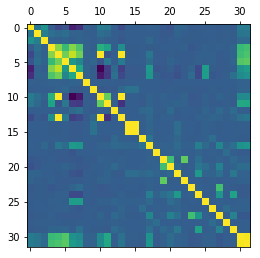

In [156]:
plt.matshow(df_numeric.corr())

In [157]:
df_col = df_numeric.columns

for i in df_col:
    print(df["nutrition-score-fr_100g"].corr(df[str(i)]))
    

0.16622669910912863
0.13051150931634883
0.0614796284209749
0.5332501162868913
0.5555849202443884
0.6170232880470525
0.3006473325574071
0.25396615575904324
0.022082227172741217
0.030842855192398735
0.25452509716615457
0.437255739839563
-0.001604710329862983
0.10013894980172619
0.0074206464426507
0.007420652772446631
-0.006559449226216225
0.3089343305313621
-0.010150962990453026
0.010053183182603162
0.07648840432750324
0.025822705605602358
0.018376956579113566
-0.024429108780398306
-0.013918995000005317
0.013892388908943055
0.016539014468626108
-0.03512009175264675
-0.0015372424161927186
0.001986072083425653
1.0
0.978636219009275


In [161]:
x=pd.DataFrame(index=df_col, columns=["correlation"])

for i in df_col:
    x.loc[i]["correlation"]=df["nutrition-score-fr_100g"].corr(df[str(i)])

    

In [162]:
x

,correlation
additives_n,0.166227
ingredients_from_palm_oil_n,0.130512
ingredients_that_may_be_from_palm_oil_n,0.0614796
energy_100g,0.53325
fat_100g,0.555585
saturated-fat_100g,0.617023
monounsaturated-fat_100g,0.300647
polyunsaturated-fat_100g,0.253966
trans-fat_100g,0.0220822
cholesterol_100g,0.0308429


In [163]:
x.sort_values("correlation")

,correlation
phosphorus_100g,-0.0351201
vitamin-b9_100g,-0.0244291
vitamin-b12_100g,-0.013919
vitamin-c_100g,-0.010151
vitamin-a_100g,-0.00655945
fiber_100g,-0.00160471
iron_100g,-0.00153724
magnesium_100g,0.00198607
salt_100g,0.00742065
sodium_100g,0.00742065


In [ ]:
# saturated fat and fat cause the highest nutritional scores